# Facial Emotion Recogination

#### batch_size = 32, num_classes = 3, epochs = 60

Importing libraries

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import load_model, save_model
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import cv2

Importing Dataset

In [3]:
train_dir = 'fer2013/modified/train/'
test_dir = 'fer2013/modified/test/'

row, col = 48, 48
classes = 3

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  happy  neutral
train   3860   6722     4648
      angry  happy  neutral
test    907   1621     1101


Creating Training and Test sets

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=32, # 64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=32, # 64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 15230 images belonging to 3 classes.
Found 3629 images belonging to 3 classes.


In [5]:
training_set.class_indices

{'angry': 0, 'happy': 1, 'neutral': 2}

Defining Model

In [6]:

# parameters
# batch_size = 32 # 64
# num_epochs = 10 #110
input_shape = (48, 48, 1)
# verbose = 1
num_classes = 3 # 7
# patience = 50
# base_path = 'models_0_2/'
l2_regularization=0.01

# # data generator
# data_generator = ImageDataGenerator(
#                         featurewise_center=False,
#                         featurewise_std_normalization=False,
#                         rotation_range=10,
#                         width_shift_range=0.1,
#                         height_shift_range=0.1,
#                         zoom_range=.1,
#                         horizontal_flip=True)
 
# model parameters
regularization = l2(l2_regularization)
 
# base
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)

In [7]:
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
#!pip install pydot
#!pip install graphviz
#!pip install pydotplus
#!pip install django-extensions
#!pip install pyparsing

In [9]:
# plot_model(model, to_file='model_0_5.png', show_shapes=True, show_layer_names=True)

Callbacks Function

In [10]:
chk_path = 'models_0_5/{epoch:02d}-{val_accuracy:.2f}.h5'
log_dir = "models_0_5/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

Training Model

In [11]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
hist = model.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
475/475 [==============================] - 177s 361ms/step - loss: 1.2031 - accuracy: 0.4648 - val_loss: 1.0882 - val_accuracy: 0.4527

Epoch 00001: val_loss improved from inf to 1.08817, saving model to models_0_5\01-0.45.h5
Epoch 2/60
475/475 [==============================] - 157s 330ms/step - loss: 0.9208 - accuracy: 0.6151 - val_loss: 0.8108 - val_accuracy: 0.6773

Epoch 00002: val_loss improved from 1.08817 to 0.81084, saving model to models_0_5\02-0.68.h5
Epoch 3/60
475/475 [==============================] - 156s 329ms/step - loss: 0.7932 - accuracy: 0.6735 - val_loss: 0.7123 - val_accuracy: 0.6980

Epoch 00003: val_loss improved from 0.81084 to 0.71235, saving model to models_0_5\03-0.70.h5
Epoch 4/60
475/475 [==============================] - 157s 331ms/step - loss: 0.7265 - accuracy: 0.7002 - val_loss: 0.6463 - val_accuracy: 0.7356

Epoch 00004: val_loss improved from 0.71235 to 0.64627, saving model to models_0_5\04-0.74.h5
Epoch 5/60
475/475 [====================

475/475 [==============================] - 168s 353ms/step - loss: 0.3991 - accuracy: 0.8426 - val_loss: 0.4495 - val_accuracy: 0.8230

Epoch 00038: val_loss did not improve from 0.44579
Epoch 39/60
475/475 [==============================] - 159s 335ms/step - loss: 0.4058 - accuracy: 0.8386 - val_loss: 0.4483 - val_accuracy: 0.8249

Epoch 00039: val_loss did not improve from 0.44579
Epoch 40/60
475/475 [==============================] - 171s 360ms/step - loss: 0.4016 - accuracy: 0.8441 - val_loss: 0.4478 - val_accuracy: 0.8249

Epoch 00040: val_loss did not improve from 0.44579

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 41/60
475/475 [==============================] - 162s 340ms/step - loss: 0.4032 - accuracy: 0.8410 - val_loss: 0.4471 - val_accuracy: 0.8258

Epoch 00041: val_loss did not improve from 0.44579
Epoch 42/60
475/475 [==============================] - 181s 382ms/step - loss: 0.3948 - accuracy: 0.8479 - val_loss: 0.4469 - val_accu

In [12]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot_0_5.png', show_shapes=True, show_layer_names=True)

Loss and Accuracy plot

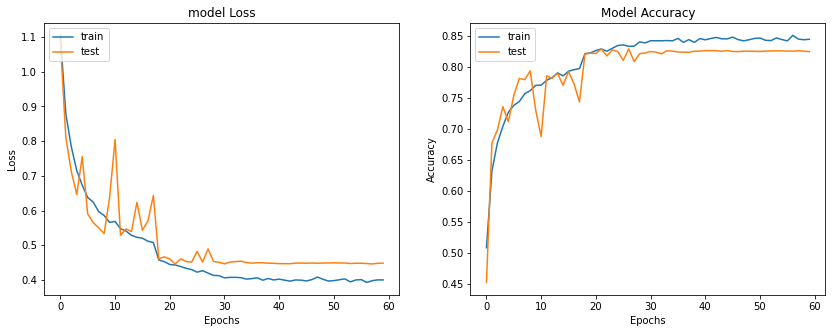

In [13]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

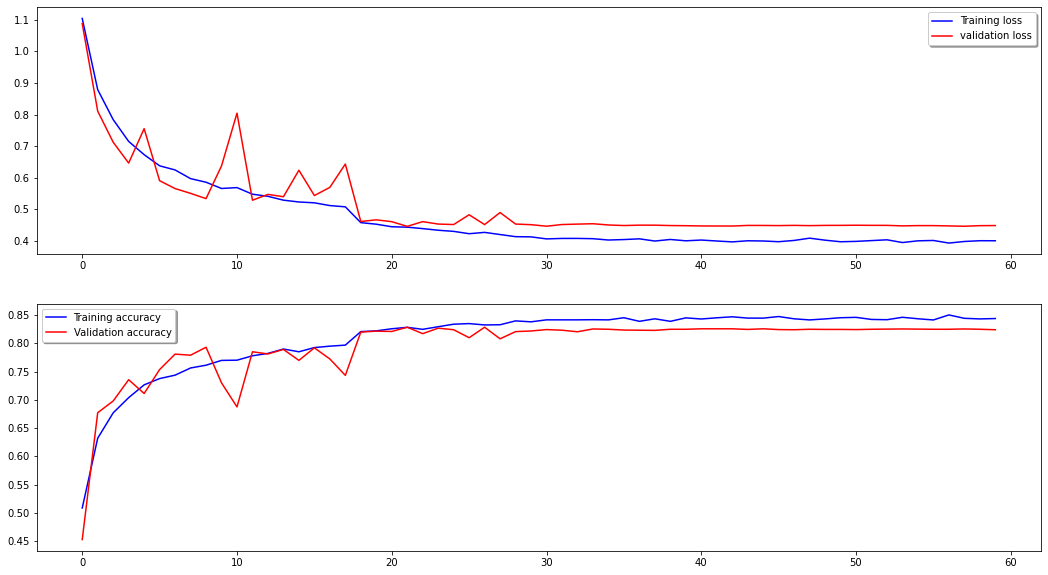

In [14]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Model Evaluation

In [15]:
train_loss, train_accu = model.evaluate(training_set)
test_loss, test_accu = model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

114/114 [==============================] - 8s 69ms/step - loss: 0.4484 - accuracy: 0.8239
final train accuracy = 84.94 , validation accuracy = 82.39


In [16]:
model.save_weights('model_bestweight_0_5.h5')
model.save('model_best_0_5.h5')

Confusion Matrix and Classification on training set

In [17]:
per = np.random.permutation(training_set.n)
training_set.index_array = per
classes = training_set.classes[per]

In [18]:
classes

array([0, 1, 2, ..., 0, 2, 1])

Confusion Matrix
[[2883  258  719]
 [ 212 6163  347]
 [ 462  376 3810]]
Classification Report
              precision    recall  f1-score   support

       angry       0.81      0.75      0.78      3860
       happy       0.91      0.92      0.91      6722
     neutral       0.78      0.82      0.80      4648

    accuracy                           0.84     15230
   macro avg       0.83      0.83      0.83     15230
weighted avg       0.84      0.84      0.84     15230



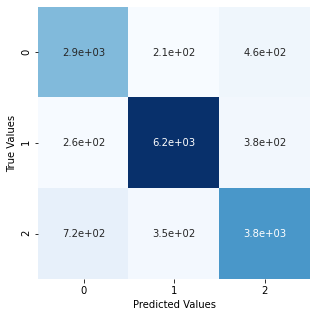

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
model = load_model('model_best_0_5.h5')
fig = plt.figure(figsize=(5, 5))

#Confution Matrix and Classification Report
class_labels = training_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}
y_pred = model.predict(training_set) 
y_pred = np.argmax(y_pred, axis=1)
mat = confusion_matrix(classes, y_pred) # Confusion matrix
print('Confusion Matrix')
print(mat)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(classes, y_pred, target_names=target_names))



# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [20]:
per = np.random.permutation(training_set.n)
training_set.index_array = per
classes = training_set.classes[per]

Confusion Matrix
[[2886  244  730]
 [ 207 6180  335]
 [ 466  363 3819]]
Classification Report
              precision    recall  f1-score   support

       angry       0.81      0.75      0.78      3860
       happy       0.91      0.92      0.91      6722
     neutral       0.78      0.82      0.80      4648

    accuracy                           0.85     15230
   macro avg       0.83      0.83      0.83     15230
weighted avg       0.85      0.85      0.85     15230



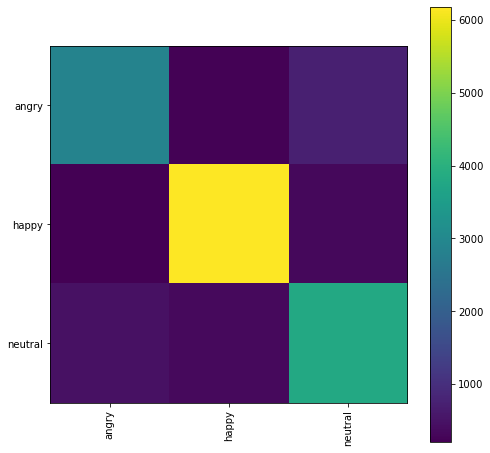

In [21]:
y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = training_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix and Classification on test set

In [22]:
per = np.random.permutation(test_set.n)
test_set.index_array = per
classes = test_set.classes[per]

Confusion Matrix
[[ 658   58  191]
 [  80 1438  103]
 [ 133   74  894]]
Classification Report
              precision    recall  f1-score   support

       angry       0.76      0.73      0.74       907
       happy       0.92      0.89      0.90      1621
     neutral       0.75      0.81      0.78      1101

    accuracy                           0.82      3629
   macro avg       0.81      0.81      0.81      3629
weighted avg       0.83      0.82      0.82      3629



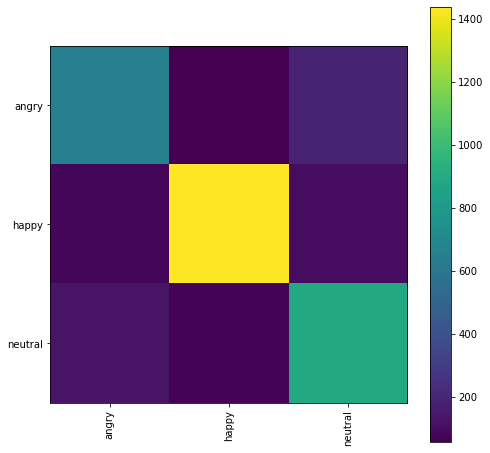

In [23]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

ROC Curve

In [24]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [25]:
per = np.random.permutation(test_set.n)
test_set.index_array = per
classes = test_set.classes[per]
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

In [26]:
multiclass_roc_auc_score(test_set.classes, y_pred)

0.5134070679485218

In [41]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import cv2
import numpy as np
import sys
import time
#from google.colab.patches import cv2_imshow
 
# parameters for loading data and images
detection_model_path = 'haarcascade_files/haarcascade_frontalface_default.xml'
#emotion_model_path = 'ferNet.h5'
emotion_model_path = 'model_best_0_5.h5'
img_path =  "angry.jpg" # sys.argv[1]
 
# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ['angry',  'happy', 'neutral'] # , 'sad', 'surprise']
 
# reading the frame
orig_frame = cv2.imread(img_path)
#print(img_path)
#print(orig_frame)
frame = cv2.imread(img_path,0)
print(frame.shape)
print(type(frame.shape))
#print(frame)
faces = face_detection.detectMultiScale(frame,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
 
if len(faces) > 0:
#     print(faces)
    faces = sorted(faces, reverse=True,key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
    (fX, fY, fW, fH) = faces
    roi = frame[fY:fY + fH, fX:fX + fW]
    print(roi)
    roi = cv2.resize(roi, (48, 48))
    roi = roi.astype("float") / 255.0
    print(roi)
    roi = img_to_array(roi)
    print(roi)
    roi = np.expand_dims(roi, axis=0)
    print(roi)
    preds = emotion_classifier.predict(roi)[0]
    emotion_probability = np.max(preds)
    label = EMOTIONS[preds.argmax()]
    cv2.putText(orig_frame, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    cv2.rectangle(orig_frame, (fX, fY), (fX + fW, fY + fH),(0, 0, 255), 2)
 
cv2.imshow('test_face', orig_frame)
#cv2_imshow(orig_frame)
cv2.imwrite('test_output/'+img_path.split('/')[-1],orig_frame)
if (cv2.waitKey(0) and 0xFF == ord('q')):
    sys.exit("Thanks")
cv2.destroyAllWindows()

(828, 828)
<class 'tuple'>
[[ 54  58  49 ... 145 151 154]
 [ 55  51  56 ... 150 150 153]
 [ 53  68  49 ... 147 146 151]
 ...
 [ 36  38  32 ...  31  26  13]
 [ 46  43  35 ...  30  27  13]
 [ 52  50  37 ...  26  33   5]]
[[0.21176471 0.18431373 0.19215686 ... 0.51372549 0.51764706 0.56470588]
 [0.24313725 0.29803922 0.16862745 ... 0.43529412 0.51372549 0.6       ]
 [0.14117647 0.13333333 0.16078431 ... 0.43137255 0.49019608 0.58039216]
 ...
 [0.12941176 0.08627451 0.12156863 ... 0.02352941 0.09411765 0.11372549]
 [0.14509804 0.1372549  0.03137255 ... 0.02352941 0.08235294 0.11372549]
 [0.10980392 0.09411765 0.09019608 ... 0.03921569 0.05490196 0.09803922]]
[[[0.21176471]
  [0.18431373]
  [0.19215687]
  ...
  [0.5137255 ]
  [0.5176471 ]
  [0.5647059 ]]

 [[0.24313726]
  [0.29803923]
  [0.16862746]
  ...
  [0.43529412]
  [0.5137255 ]
  [0.6       ]]

 [[0.14117648]
  [0.13333334]
  [0.16078432]
  ...
  [0.43137255]
  [0.49019608]
  [0.5803922 ]]

 ...

 [[0.12941177]
  [0.08627451]
  [0.12

In [ ]:
roi.shape

# 실시간 영상을 통한 결과 확인

In [37]:
from statistics import mode

import cv2
from keras.models import load_model
import numpy as np

from utils.datasets import get_labels
from utils.inference import detect_faces
from utils.inference import draw_text
from utils.inference import draw_bounding_box
from utils.inference import apply_offsets
from utils.inference import load_detection_model
from utils.preprocessor import preprocess_input

# parameters for loading data and images
detection_model_path = 'haarcascade_files/haarcascade_frontalface_default.xml'
emotion_model_path = 'model_best_0_5.h5'
emotion_labels = ['angry',  'happy', 'neutral'] # ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# hyper-parameters for bounding boxes shape
frame_window = 10
emotion_offsets = (20, 40)

# loading models
face_detection = load_detection_model(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)

# getting input model shapes for inference
emotion_target_size = emotion_classifier.input_shape[1:3]

# starting lists for calculating modes
emotion_window = []

In [38]:
face_detection

<CascadeClassifier 000001D60E617550>

In [39]:
emotion_labels

['angry', 'happy', 'neutral']

In [40]:
from keras.preprocessing.image import img_to_array

# starting video streaming
cv2.namedWindow('window_frame')
video_capture = cv2.VideoCapture(0)
while True:
    bgr_image = video_capture.read()[1]
    gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    faces = detect_faces(face_detection, gray_image)
    
    for face_coordinates in faces:

        x1, x2, y1, y2 = apply_offsets(face_coordinates, emotion_offsets)
        gray_face = gray_image[y1:y2, x1:x2]
        try:
            gray_face = cv2.resize(gray_face, (emotion_target_size))
        except:
            continue

        gray_face = preprocess_input(gray_face, True)
        gray_face = np.expand_dims(gray_face, 0)
        gray_face = np.expand_dims(gray_face, -1)
        emotion_prediction = emotion_classifier.predict(gray_face)
        emotion_probability = np.max(emotion_prediction)
        emotion_label_arg = np.argmax(emotion_prediction)
        emotion_text = emotion_labels[emotion_label_arg]
        emotion_window.append(emotion_text)

        if len(emotion_window) > frame_window:
            emotion_window.pop(0)
        try:
            emotion_mode = mode(emotion_window)
        except:
            continue

        if emotion_text == 'angry':
            color = emotion_probability * np.asarray((255, 0, 0))
        elif emotion_text == 'happy':
            color = emotion_probability * np.asarray((0, 0, 255))
        elif emotion_text == 'neutral':
            color = emotion_probability * np.asarray((255, 255, 0))
        elif emotion_text == 'sad':
            color = emotion_probability * np.asarray((0, 255, 255))
        else:
            color = emotion_probability * np.asarray((0, 255, 0))

        color = color.astype(int)
        color = color.tolist()

        draw_bounding_box(face_coordinates, rgb_image, color)
        if emotion_probability >= 0.7:
            draw_text(face_coordinates, rgb_image, emotion_mode,
                      color, 0, -45, 1, 1)
        draw_text(face_coordinates, rgb_image, str(emotion_labels[0])+' : '+str(round(emotion_prediction[0][0],2)),
                  [0, 99, 99], 250, 10, 1, 1)
        draw_text(face_coordinates, rgb_image, str(emotion_labels[1])+' : '+str(round(emotion_prediction[0][1],2)),
                  [99, 0, 99], 250, 60, 1, 1)
        draw_text(face_coordinates, rgb_image, str(emotion_labels[2])+' : '+str(round(emotion_prediction[0][2],2)),
                  [0, 99, 0], 250, 110, 1, 1)
        #draw_text(face_coordinates, rgb_image, str(emotion_labels[3])+' : '+str(round(emotion_prediction[0][6],2)),
        #          [0, 0, 0], 250, 160, 1, 1)
        
        
        
    bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
    cv2.imshow('window_frame', bgr_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

In [24]:
emotion_prediction

array([[0.18659161, 0.0593199 , 0.7540885 ]], dtype=float32)